# Building our handwritten singular value decomposition and applying it to image compression
## Step 1. Import nessary libraries
Even though we're not using SVD functionalities from Numpy, we are going to use some other function that will be helpful on creating our own SVD function

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, transform
from skimage.util import img_as_float

## Step 2. Creating our QR decomposition function
As explained in the slides, we are going to use to QR decomposition via householder reflection for finding our eigenvalues and eigenvectors.

#### 2.1. Create a matrix for our example, copy it and ensure it is float type

In [50]:
X = np.array([
    [3, 1],
    [1, 3],
    [1, 1]
])
A = np.array(X, dtype=float)
m, n = A.shape

#### 2.2 Initialize Q as identity $m * m$ matrix.
We will use np.eye(n) function that will generate a square matrix of size n

In [51]:
Q = np.eye(m)
Q

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

#### 2.3 Work on each colum k up to $min(m, n) - 1$
Then we will:
- Extract x: the k-th column from row k to $m-1$.
- Shape (m-k,)
- Compute the norm of x. We will use np.linalg.norm(x, ord=2) to get the norm of x.
- Check signs to avoid cancellation.
- Form $v = \text{sign} * ||x||_{2} * e1$.
- If v is almost zero, skip
- Householder submatrix: $H_{sub} = I - 2 * v v^T / (v^T v)$. Instead of forming $H_{full}$ explicitly for the whole matrix, we will build $H_{full}$ and apply.
- Build full-size Householder $H_k (m * m)$, identity except lower-right block replaced
- Apply $H_k$ on left to A ($A <- H_k * A$)
- Accumulate $Q = Q * H_k$ (so final $Q = H1*H2*...*H_{n-1}$)

In [52]:
for k in range(min(m, n)):
        # Extract x: the k-th column from row k to m-1
        x = A[k:, k].copy()           # Shape (m-k,)

        # Compute norm of x
        norm_x = np.linalg.norm(x, ord=2)

        if norm_x == 0.0:
            # Nothing to do for this column
            continue

        # sign to avoid cancellation: sign = 1 if x0 >=0 else -1
        sign = 1.0 if x[0] >= 0.0 else -1.0

        # Form v = x + sign * ||x|| * e1
        e1 = np.zeros_like(x)
        e1[0] = 1.0
        v = x + sign * norm_x * e1

        # If v is zero, skip
        v_norm_sq = (v * v).sum()
        if v_norm_sq == 0.0:
            continue

        # Householder submatrix: H_sub = I - 2 * v v^T / (v^T v)
        # Instead of forming H_full explicitly for whole matrix, we will build H_full and apply.
        H_sub = np.eye(v.shape[0]) - 2.0 * np.outer(v, v) / v_norm_sq

        # Build full-size Householder H_k (m x m), identity except lower-right block replaced
        H_k = np.eye(m)
        H_k[k:, k:] = H_sub

        # Apply H_k on left to A (A <- H_k @ A)
        A = H_k @ A

        # Accumulate Q = Q @ H_k (so final Q = H1 H2 ... H_{n-1})
        Q = Q @ H_k

#### 2.4 Check that our QR decomposition algorithm works as intended.
After all reflections, A has become R.

In [53]:
R = A
R

array([[-3.31662479e+00, -2.11057941e+00],
       [ 9.00351949e-17, -2.55840860e+00],
       [-9.50496722e-17, -3.25364545e-18]])

In [54]:
Q

array([[-0.90453403,  0.35533453, -0.23570226],
       [-0.30151134, -0.92386977, -0.23570226],
       [-0.30151134, -0.14213381,  0.94280904]])

In [55]:
Q@R

array([[3., 1.],
       [1., 3.],
       [1., 1.]])

#### 2.5 Put all this in a function.

In [56]:
def householder_qr(A):
    A = np.array(A, dtype=float)
    m, n = A.shape
    Q = np.eye(m)
    for k in range(min(m, n)):
        x = A[k:, k].copy()
        norm_x = np.linalg.norm(x, ord=2)
        if norm_x == 0.0:
            continue
        sign = 1.0 if x[0] >= 0.0 else -1.0
        e1 = np.zeros_like(x)
        e1[0] = 1.0
        v = x + sign * norm_x * e1
        v_norm_sq = (v * v).sum()
        if v_norm_sq == 0.0:
            continue
        H_sub = np.eye(v.shape[0]) - 2.0 * np.outer(v, v) / v_norm_sq
        H_k = np.eye(m)
        H_k[k:, k:] = H_sub
        A = H_k @ A
        Q = Q @ H_k
    R = A

    return Q, R

#### Tests

In [57]:
B = np.random.randint(1,101,(3,4))
B

array([[ 63,  18,  90,  44],
       [ 34,  74,  62, 100],
       [ 14,  95,  48,  15]], dtype=int32)

In [58]:
Q, R = householder_qr(B)
B = Q@R
B

array([[ 63.,  18.,  90.,  44.],
       [ 34.,  74.,  62., 100.],
       [ 14.,  95.,  48.,  15.]])

In [59]:
C = np.random.randint(1,101,(10,15))
C

array([[72, 78, 87, 62, 40, 85, 80, 82, 53, 24, 26, 89, 60, 41, 29],
       [15, 45, 65, 89, 71,  9, 88,  1,  8, 88, 63, 11, 81,  8, 35],
       [35, 33,  5, 41, 28,  7, 73, 72, 12, 34, 33, 48, 23, 62, 88],
       [37, 99, 44, 86, 91, 35, 65, 99, 47, 78,  3,  1,  5, 90, 14],
       [27,  9, 79, 15, 90, 42, 77, 51, 63, 96, 52, 96,  4, 94, 23],
       [15, 43, 29, 36, 13, 32, 71, 59, 86, 28, 66, 42, 45, 62, 57],
       [ 6, 28, 28, 44, 84, 30, 62, 75, 92, 89, 62, 97,  1, 27, 62],
       [77,  3, 70, 72, 27,  9, 62, 37, 97, 51, 44, 24, 79, 59, 32],
       [96, 88, 52, 62, 58, 52, 12, 39,  2,  3, 56, 81, 59,  2,  2],
       [92, 54, 87, 96, 97,  1, 19,  2, 53, 44, 90, 32, 70, 32, 68]],
      dtype=int32)

In [60]:
Q, R = householder_qr(C)
C = Q@R
C

array([[72., 78., 87., 62., 40., 85., 80., 82., 53., 24., 26., 89., 60.,
        41., 29.],
       [15., 45., 65., 89., 71.,  9., 88.,  1.,  8., 88., 63., 11., 81.,
         8., 35.],
       [35., 33.,  5., 41., 28.,  7., 73., 72., 12., 34., 33., 48., 23.,
        62., 88.],
       [37., 99., 44., 86., 91., 35., 65., 99., 47., 78.,  3.,  1.,  5.,
        90., 14.],
       [27.,  9., 79., 15., 90., 42., 77., 51., 63., 96., 52., 96.,  4.,
        94., 23.],
       [15., 43., 29., 36., 13., 32., 71., 59., 86., 28., 66., 42., 45.,
        62., 57.],
       [ 6., 28., 28., 44., 84., 30., 62., 75., 92., 89., 62., 97.,  1.,
        27., 62.],
       [77.,  3., 70., 72., 27.,  9., 62., 37., 97., 51., 44., 24., 79.,
        59., 32.],
       [96., 88., 52., 62., 58., 52., 12., 39.,  2.,  3., 56., 81., 59.,
         2.,  2.],
       [92., 54., 87., 96., 97.,  1., 19.,  2., 53., 44., 90., 32., 70.,
        32., 68.]])

In [61]:
D = np.random.randint(-50,51,(5,5))
D

array([[  4,  24,   5, -34, -13],
       [-27,  18,  47,  19,  35],
       [-40, -35,  46,  22,   8],
       [ 19,  29,  42, -48, -31],
       [  8, -15, -32,  39,  16]], dtype=int32)

In [62]:
Q, R = householder_qr(D)
D = Q@R
D

array([[  4.,  24.,   5., -34., -13.],
       [-27.,  18.,  47.,  19.,  35.],
       [-40., -35.,  46.,  22.,   8.],
       [ 19.,  29.,  42., -48., -31.],
       [  8., -15., -32.,  39.,  16.]])

## Step 3. Creating our Singular Value Decomposition Function
Now that we have a way to get our eigenvalues and eigenvectors, we can start creating our SVD Function.

#### 3.1 Form the symmetric matrix
For the matrix example we are going to reuse matrix A

In [63]:
A = np.array([
    [3, 1],
    [1, 3],
    [1, 1]
])
m, n = A.shape
S = A.T @ A
S

array([[11,  7],
       [ 7, 11]])

#### 3.2 Compute eigenvalues and eigenvector of S
A_k will be our matrix in the QR iteration and V will be our accumulator for eigenvectors

In [64]:
A_k = S.copy()
V = np.eye(n)

#### 3.3 Calculate Q and R using our householder_qr function
**Note that**: The QR algorithm is an **iterative method**, meaning it doesn't calculate the answer in one single math step. Instead, it guesses the answer, then refines that guess over and over again. For that reason, depending on the number of iterations, our singular values will become more accurate or less accurate.

For this example we will use 5 iterations to start.

In [65]:
for i in range(5):
    Q, R = householder_qr(A_k)  # A_k = Q @ R
    A_k = R @ Q                 # A_(k+1) = R @ Q
    V = V @ Q                   # accumulate eigenvectors

After iterations, A_k diagonal is an approximation of eigenvalues. We use np.diag() function to get the diagonal of a matrix.

In [66]:
eigenvalues = np.diag(A_k)
eigenvalues

array([17.99999589,  4.00000411])

V will be our eigen vectors

In [67]:
V

array([[-0.70748987,  0.70672348],
       [-0.70672348, -0.70748987]])

#### 3.4 Get the singular values and sort them.
We use Numpy function sqrt() to get the square root of an array.

In [68]:
singular_values = np.sqrt(np.abs(eigenvalues))
singular_values

array([4.2426402 , 2.00000103])

Sort them in descending order. We use Numpy function argsort to get the indices that would sort our array.

In [69]:
sort_indices = np.argsort(singular_values)[::-1]
singular_values = singular_values[sort_indices]

Sort V columns as well so it matches singular values' order

In [70]:
V = V[:, sort_indices]
V

array([[-0.70748987,  0.70672348],
       [-0.70672348, -0.70748987]])

#### 3.5 Construct the Sigma Matrix
Sigma is (min(m,n), min(m,n)) diagonal. We use Numpy function np.fill_diagonal here to place the singular values through the diagonal.

In [71]:
min_dimension = min(m, n)
Sigma = np.zeros((min_dimension, min_dimension))
np.fill_diagonal(Sigma, singular_values[:min_dimension])
Sigma

array([[4.2426402 , 0.        ],
       [0.        , 2.00000103]])

#### 3.6 Compute U
U is (m, min(m,n)). When we are trying to calculate U, we avoid dividing by singular values that are too small. Instead, we just leave U as zero.

In [72]:
U = np.zeros((m, min_dimension))
for i in range(min_dimension):
    sigma = singular_values[i]
    if sigma > 1e-12:
           U[:, i] = (A @ V[:, i]) / sigma
    else:
        # leave as zeros;
        U[:, i] = 0.0

U

array([[-6.66847286e-01,  7.06339920e-01],
       [-6.66486004e-01, -7.07872708e-01],
       [-3.33333322e-01, -3.83197041e-04]])

#### 3.7 Check our SVD Decomposition algorithm work as intended

In [73]:
U @ Sigma @ V.T

array([[3., 1.],
       [1., 3.],
       [1., 1.]])

#### 3.8 Put our algorithm in a function to be reused later

In [74]:
import numpy as np
def handwritten_svd(A, num_iterations=100):     #100 iterations for numerical stability
    m, n = A.shape
    S = A.T @ A
    A_k = S.copy()
    V = np.eye(n)
    for i in range(num_iterations):
        Q, R = householder_qr(A_k)
        A_k = R @ Q
        V = V @ Q
    eigenvalues = np.diag(A_k)
    singular_values = np.sqrt(np.abs(eigenvalues))
    sort_indices = np.argsort(singular_values)[::-1]
    singular_values = singular_values[sort_indices]
    V = V[:, sort_indices]
    min_dimension = min(m, n)
    Sigma = np.zeros((min_dimension, min_dimension))
    np.fill_diagonal(Sigma, singular_values[:min_dimension])
    U = np.zeros((m, min_dimension))

    for i in range(min_dimension):
        sigma = singular_values[i]
        if sigma > 1e-12:  # Avoid division by zero
            U[:, i] = (A @ V[:, i]) / sigma
        else:
            U[:, i] = 0.0
    return U, Sigma, V.T

#### Tests

In [75]:
B = np.random.randint(1,101,(4,4))
B

array([[19, 20, 96, 71],
       [52, 33, 40, 39],
       [82,  1, 11, 92],
       [57, 89, 50, 23]], dtype=int32)

In [76]:
U, Sigma, V_T = handwritten_svd(B, 100)
U @ Sigma @ V_T

array([[19., 20., 96., 71.],
       [52., 33., 40., 39.],
       [82.,  1., 11., 92.],
       [57., 89., 50., 23.]])

In [77]:
C = np.random.randint(-50, 51,(15,10))
C

array([[-20,  43,  -9,  48, -44, -35,  39,   9, -49, -50],
       [ -3, -39,  18, -14, -19, -42,  48, -32,  -3,  29],
       [-48, -31, -27,   3, -18, -27,  24,  21, -15, -13],
       [ 33,  48,  38,  48, -26,  42, -33,  31,  15,   3],
       [-16,  29,  10, -10,  49, -18,  17, -18, -37, -30],
       [ -3, -31, -43, -44,  16, -34, -18,  -3,  25,   8],
       [ 35, -29, -21, -13,   0,   3, -43, -24, -24,  47],
       [-30, -21,  46, -23,  13,  46,  18,  10,  -3, -32],
       [-47, -16,  13,  -2, -34,  -7,  41, -21,  42,  -5],
       [-45,  48, -14, -27,  42,  -5,   2,  44,  48,   9],
       [ 46,  12,  34, -19,  36, -18,  16, -33, -26,  44],
       [  3,   7,  16,  -5, -27, -19,  -4,  35, -28,  15],
       [-24, -49,  39, -34, -18, -42,  -8,  -3, -12,  42],
       [ -9, -25,  48,  -1, -26, -27, -38,   9, -44,   6],
       [-15,  -6, -31,  14, -43, -35, -37,  25,  36, -36]], dtype=int32)

In [78]:
U, Sigma, V_T = handwritten_svd(C, 100)
U @ Sigma @ V_T

array([[-2.00000000e+01,  4.30000000e+01, -9.00000000e+00,
         4.80000000e+01, -4.40000000e+01, -3.50000000e+01,
         3.90000000e+01,  9.00000000e+00, -4.90000000e+01,
        -5.00000000e+01],
       [-3.00000000e+00, -3.90000000e+01,  1.80000000e+01,
        -1.40000000e+01, -1.90000000e+01, -4.20000000e+01,
         4.80000000e+01, -3.20000000e+01, -3.00000000e+00,
         2.90000000e+01],
       [-4.80000000e+01, -3.10000000e+01, -2.70000000e+01,
         3.00000000e+00, -1.80000000e+01, -2.70000000e+01,
         2.40000000e+01,  2.10000000e+01, -1.50000000e+01,
        -1.30000000e+01],
       [ 3.30000000e+01,  4.80000000e+01,  3.80000000e+01,
         4.80000000e+01, -2.60000000e+01,  4.20000000e+01,
        -3.30000000e+01,  3.10000000e+01,  1.50000000e+01,
         3.00000000e+00],
       [-1.60000000e+01,  2.90000000e+01,  1.00000000e+01,
        -1.00000000e+01,  4.90000000e+01, -1.80000000e+01,
         1.70000000e+01, -1.80000000e+01, -3.70000000e+01,
        -3.

In [79]:
U

array([[-0.36600074, -0.31584075,  0.50474584, -0.14392748,  0.3685579 ,
        -0.02136225,  0.10518563,  0.04726471, -0.03005693, -0.32014605],
       [ 0.36659595, -0.26650201,  0.14973578, -0.14130105, -0.02451423,
         0.28239028,  0.32133901, -0.00923253,  0.22143477,  0.20386602],
       [-0.00607776, -0.45087645,  0.02611628,  0.02468121,  0.07669309,
        -0.09475183, -0.15746104,  0.48323827, -0.08558108,  0.5041511 ],
       [-0.35424771,  0.39368001,  0.22165119,  0.24387942, -0.3130931 ,
         0.00711755,  0.29684364, -0.05459737, -0.02526259,  0.18246609],
       [-0.02872842, -0.00768463,  0.05129039, -0.48473431,  0.26105956,
        -0.32587543, -0.1808323 , -0.3893132 , -0.21196431,  0.02419777],
       [ 0.23501851, -0.15913566, -0.38937539,  0.18076486,  0.23268351,
        -0.10830562, -0.06697923, -0.163582  ,  0.32782936, -0.20612048],
       [ 0.33981657,  0.24083959,  0.00428362,  0.30517286,  0.20916916,
         0.04600948, -0.17359704,  0.22384872

In [80]:
Sigma

array([[174.01441141,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        , 161.55383051,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 145.58698272,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 133.77034094,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        112.92231195,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  97.86259762,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

## Step 3. Application of SVD Decomposition on Image Compression


#### Quick review of how Image compression via SVD work
1. Represent the image in an m x n matrix, where m = height and n = width, each pixel is a value, and the value is the pixel intensity.
2. Get the SVD Decomposition of this matrix. Remember:
The SVD factorization $A = U\Sigma V^T$ can be expressed as a sum of $r$ rank-1 matrices, where $r$ is the rank of $A$: $$A = \sum_{i=1}^r \sigma_i u_i v_i^T = \sigma_1 u_1 v_i^T + \sigma_2 u_2 v_2^T + \dots + \sigma_r u_r v_r^T$$
3. Keep the top k values of the expression above.
4. Reconstruct the image from k values.


#### 3.1 Computing the SVD Compression (get k top values)

In [81]:
np.random.seed(42)
A = np.random.randint(1, 3, (10, 10))
m, n = A.shape
A

array([[1, 2, 1, 1, 1, 2, 1, 1, 1, 2],
       [1, 1, 1, 1, 2, 1, 2, 2, 2, 1],
       [2, 1, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 2, 2, 1, 2, 1, 1, 1],
       [1, 1, 2, 2, 2, 2, 2, 1, 2, 2],
       [1, 2, 1, 2, 1, 2, 2, 1, 1, 1],
       [1, 1, 1, 1, 1, 2, 2, 1, 2, 2],
       [2, 2, 1, 2, 1, 2, 2, 2, 1, 2],
       [1, 2, 1, 2, 1, 1, 2, 1, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 1]], dtype=int32)

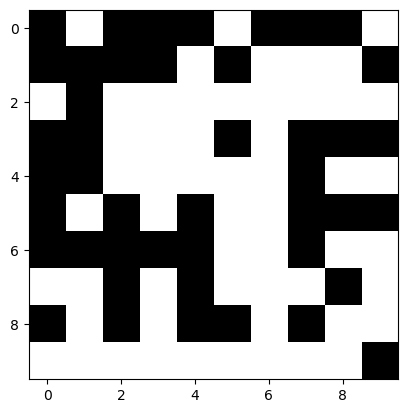

In [82]:
fig, axes = plt.subplots()
axes.imshow(A, cmap='gray')

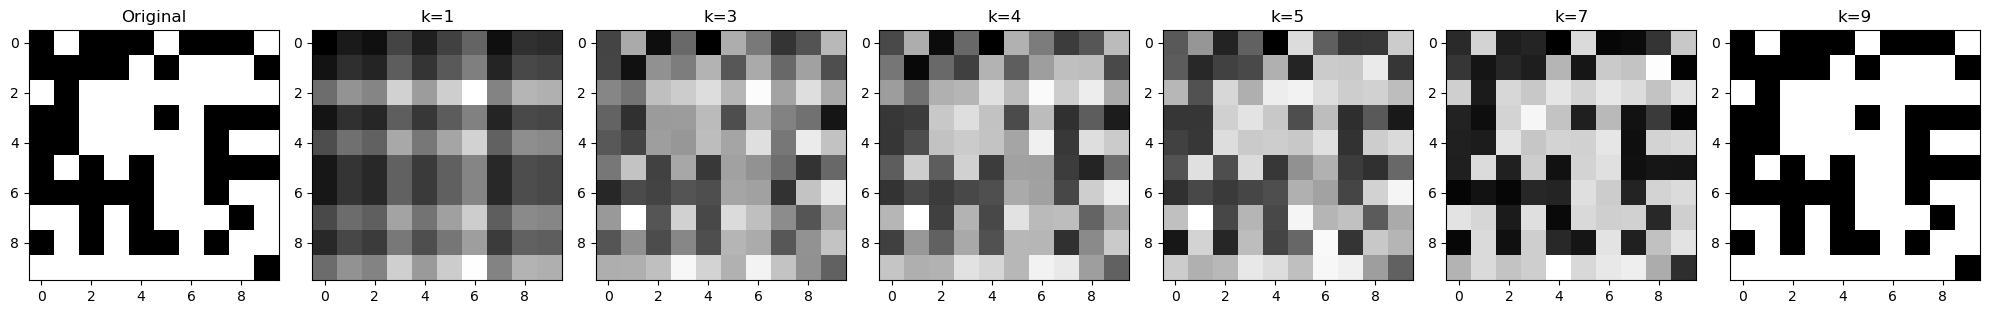

In [83]:
U, Sigma, V_T = handwritten_svd(A, 30)
k_list = [1, 3, 4, 5, 7, 9]
fig, axes = plt.subplots(1, len(k_list)+1, figsize=(20, 20))
axes[0].imshow(A, cmap='gray')
axes[0].set_title("Original")
for i, k in enumerate(k_list, start=1):
    U_k = U[:,:k]
    Sigma_k = Sigma[:k,:k]
    V_T_k = V_T[:k,:]
    # Reconstruct
    A_k = U_k @ Sigma_k @ V_T_k
    axes[i].imshow(A_k, cmap='gray')
    axes[i].set_title(f"k={k}")
plt.tight_layout()
plt.show()

#### 3.2 Create our Image Compression Function


In [84]:
def computeSvdCompression(imageMatrix, k):
    U, Sigma, V_T = handwritten_svd(imageMatrix)
    U_k = U[:,:k]
    Sigma_k = Sigma[:k,:k]
    V_T_k = V_T[:k,:]
    # Reconstruct
    A_k = U_k @ Sigma_k @ V_T_k
    return A_k

#### 3.3 Create a Helper method to compute storage usage and ratio
The original image size is just width (m) * height (n).

In [85]:
original = m * n
original

100

To compute approximate storage for rank-k representation we have to: $$m_k + n_k + k \text{ } (U_k, V_k, \text{and } k \text{ singular values)}$$

In [86]:
compressed = []
for k in k_list:
    compressed.append( (m * k) + (n * k) + k)
compressed

[21, 63, 84, 105, 147, 189]

**Remember**: Compression only works if: $$ k \lt \frac{mn}{(m+n+1)} \approx n/2$$
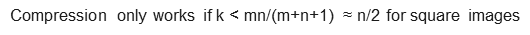
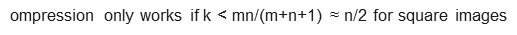

Finally get the reduction ratio to compare

In [87]:
reductionRatio = compressed[2] / original
reductionRatio

0.84

#### 3.4 Create our stats function


In [88]:
def stats(m, n, k = 0):
    original = m * n
    if k == 0:
        return original
    compressed = (m * k) + (n * k) + k
    reductionRatio = compressed / original
    return original, compressed, reductionRatio

#### 3.5 Image compression example
Load the image

In [89]:
img = data.camera()
img

array([[200, 200, 200, ..., 189, 190, 190],
       [200, 199, 199, ..., 190, 190, 190],
       [199, 199, 199, ..., 190, 190, 190],
       ...,
       [ 25,  25,  27, ..., 139, 122, 147],
       [ 25,  25,  26, ..., 158, 141, 168],
       [ 25,  25,  27, ..., 151, 152, 149]], shape=(512, 512), dtype=uint8)

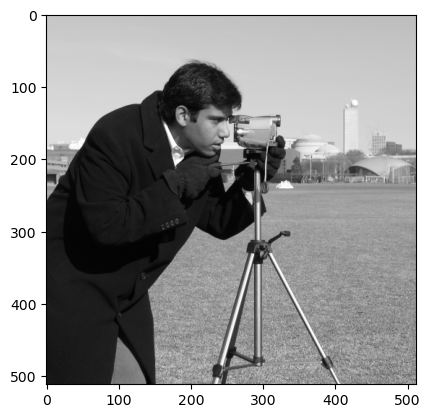

In [90]:
plt.imshow(img, cmap='gray')
plt.show()

In [91]:
m, n = img.shape
m, n

(512, 512)

In [92]:
stats(m, n)

262144

We have to transform the image to floating-point numbers because the SVD algorithm requires the input to be a floating-point matrix for mathematical stability and accurate computation.

In [93]:
imgFloat = img_as_float(img)
imgFloat

array([[0.78431373, 0.78431373, 0.78431373, ..., 0.74117647, 0.74509804,
        0.74509804],
       [0.78431373, 0.78039216, 0.78039216, ..., 0.74509804, 0.74509804,
        0.74509804],
       [0.78039216, 0.78039216, 0.78039216, ..., 0.74509804, 0.74509804,
        0.74509804],
       ...,
       [0.09803922, 0.09803922, 0.10588235, ..., 0.54509804, 0.47843137,
        0.57647059],
       [0.09803922, 0.09803922, 0.10196078, ..., 0.61960784, 0.55294118,
        0.65882353],
       [0.09803922, 0.09803922, 0.10588235, ..., 0.59215686, 0.59607843,
        0.58431373]], shape=(512, 512))

Now we have to resize the image and make it smaller. We do this because pure python $O(N^3)$ on an image like the one from our example (512 x 512) will take ~30-60 mins.

For this we will use the Scikit-image function "transform" that lets us do multiple transformations on a matrix.

In [94]:
imgFloat = transform.resize(imgFloat, (64, 64), anti_aliasing=True)

m, n = imgFloat.shape
m, n

(64, 64)

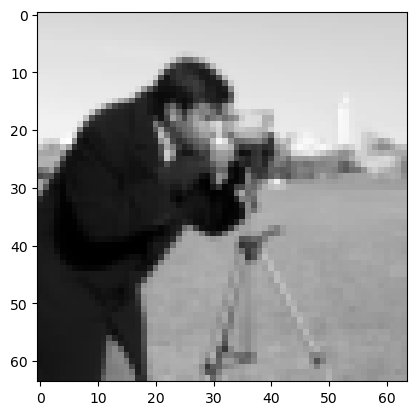

In [95]:
plt.imshow(imgFloat, cmap='gray')
plt.show()

Prepare our k values and images' layout.

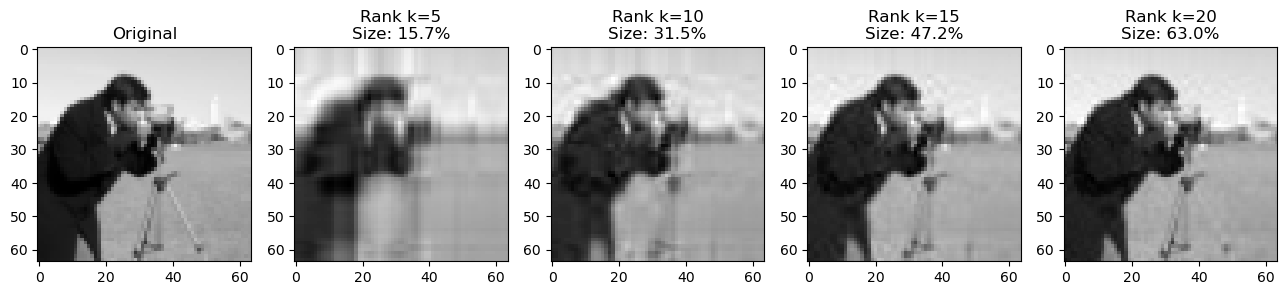

In [96]:
k_val = [5, 10, 15, 20]
fig, axes = plt.subplots(1, len(k_val)+1, figsize=(16,8))

# Original
axes[0].imshow(imgFloat, cmap='gray')
axes[0].set_title("Original")

# Reconstructions
for i, k in enumerate(k_val, start=1):
    reconstruct = computeSvdCompression(imgFloat, k)

    # Stats
    orig_sz, comp_sz, ratio = stats(m, n, k)
    axes[i].imshow(reconstruct, cmap='gray')
    axes[i].set_title(f"Rank k={k}\nSize: {ratio:.1%}")

plt.show()